<a href="https://colab.research.google.com/github/awenroberts/QM2-Project/blob/main/awen_protests_visualisation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Spatial graph and data analisis

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pylab
from datetime import datetime

%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 8)

In [ ]:
df = pd.read_excel("/content/Copy support-local-authority-datasets-sep-2025.xlsx",
                   sheet_name="2025",
                   engine='openpyxl')
df.head()

,event_id,date,location_name,town_city,postcode,description,wiki ref,source_url
0,U0011,2025-08-08,Hotel protest and counter-protest,Liverpool,L1 1JW,Two groups faced off at a hotel; some counter-...,124,https://news.sky.com/story/migrant-protesters-...
1,E0060,2025-09-06,Protest,Aberdeen,AB10 1BL,Arrest reported as protesters gathered.,193,https://www.pressandjournal.co.uk/fp/news/6845...
2,E0036,2025-08-02,Demonstration outside accommodation,Aberdeen,AB25 1XF,Arrests/charges under Hate Crime Act reported.,102,https://www.bbc.co.uk/news/articles/cy8jde62697o
3,E0004,2025-05-17,City centre march → Victoria Square,Birmingham,B1 1BD,Britain First supporters marched; council said...,49,https://www.birminghammail.co.uk/news/midlands...
4,E0048,2025-08-15,Asylum hotel protest,Sutton Coldfield,B76 1LH,Protest at asylum hotel reported.,136,https://www.birminghammail.co.uk/news/midlands...


In [ ]:
import pandas as pd

xls = pd.ExcelFile("/content/Copy support-local-authority-datasets-sep-2025.xlsx")
print("Available Excel sheets:", xls.sheet_names)

Available Excel sheets: ['Cover_sheet', 'Contents', 'Notes', 'List_of_Fields', 'Asy_D11', 'Data_Asy_D11', 'Data_Asy_20242025', 'Data_Asy_2425', 'Data_Asy_D11_2020_2025', 'population_per_LA', 'la_exposure_table', 'Sheet4', 'la_exposure_table_old', '2025', 'protest_data', 'population for local authoritie']


In [ ]:
!pip install pgeocode

import pgeocode
geo = pgeocode.Nominatim("gb")

In [ ]:
df["postcode"] = (
    df["postcode"]
    .astype(str)
    .str.upper()
    .str.strip()
)

In [ ]:
coords = df["postcode"].apply(geo.query_postal_code)

df["latitude"] = coords["latitude"]
df["longitude"] = coords["longitude"]

df.head()

,event_id,date,location_name,town_city,postcode,description,wiki ref,source_url,latitude,longitude
0,U0011,2025-08-08,Hotel protest and counter-protest,Liverpool,L1 1JW,Two groups faced off at a hotel; some counter-...,124,https://news.sky.com/story/migrant-protesters-...,53.41060,-2.977900
1,E0060,2025-09-06,Protest,Aberdeen,AB10 1BL,Arrest reported as protesters gathered.,193,https://www.pressandjournal.co.uk/fp/news/6845...,57.14370,-2.098100
2,E0036,2025-08-02,Demonstration outside accommodation,Aberdeen,AB25 1XF,Arrests/charges under Hate Crime Act reported.,102,https://www.bbc.co.uk/news/articles/cy8jde62697o,57.14370,-2.098100
3,E0004,2025-05-17,City centre march → Victoria Square,Birmingham,B1 1BD,Britain First supporters marched; council said...,49,https://www.birminghammail.co.uk/news/midlands...,52.48140,-1.899800
4,E0048,2025-08-15,Asylum hotel protest,Sutton Coldfield,B76 1LH,Protest at asylum hotel reported.,136,https://www.birminghammail.co.uk/news/midlands...,52.54015,-1.752717


In [ ]:
df = df.dropna(subset=["latitude", "longitude"])
print("Remaining events:", len(df))


Remaining events: 126


In [ ]:
city_coords = (
    df.groupby("town_city")[["latitude", "longitude"]]
      .mean()
      .reset_index()
)

city_coords.head()

,town_city,latitude,longitude
0,Aberdeen,57.14370,-2.098100
1,Altrincham,53.38524,-2.365540
2,Ashford,51.15110,0.890813
3,Barnwood (Gloucester),51.82706,-2.187810
4,Basingstoke,51.26250,-1.087100


In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [ ]:
import networkx as nx

G = nx.Graph()

# Add nodes with coordinates
for _, row in city_coords.iterrows():
    G.add_node(
        row["town_city"],
        lat=row["latitude"],
        lon=row["longitude"]
    )

In [ ]:
threshold_km = 100

for i, r1 in city_coords.iterrows():
    for j, r2 in city_coords.iterrows():
        if i < j:
            d = haversine(
                r1.latitude, r1.longitude,
                r2.latitude, r2.longitude
            )
            if d <= threshold_km:
                G.add_edge(r1.town_city, r2.town_city, distance=d)

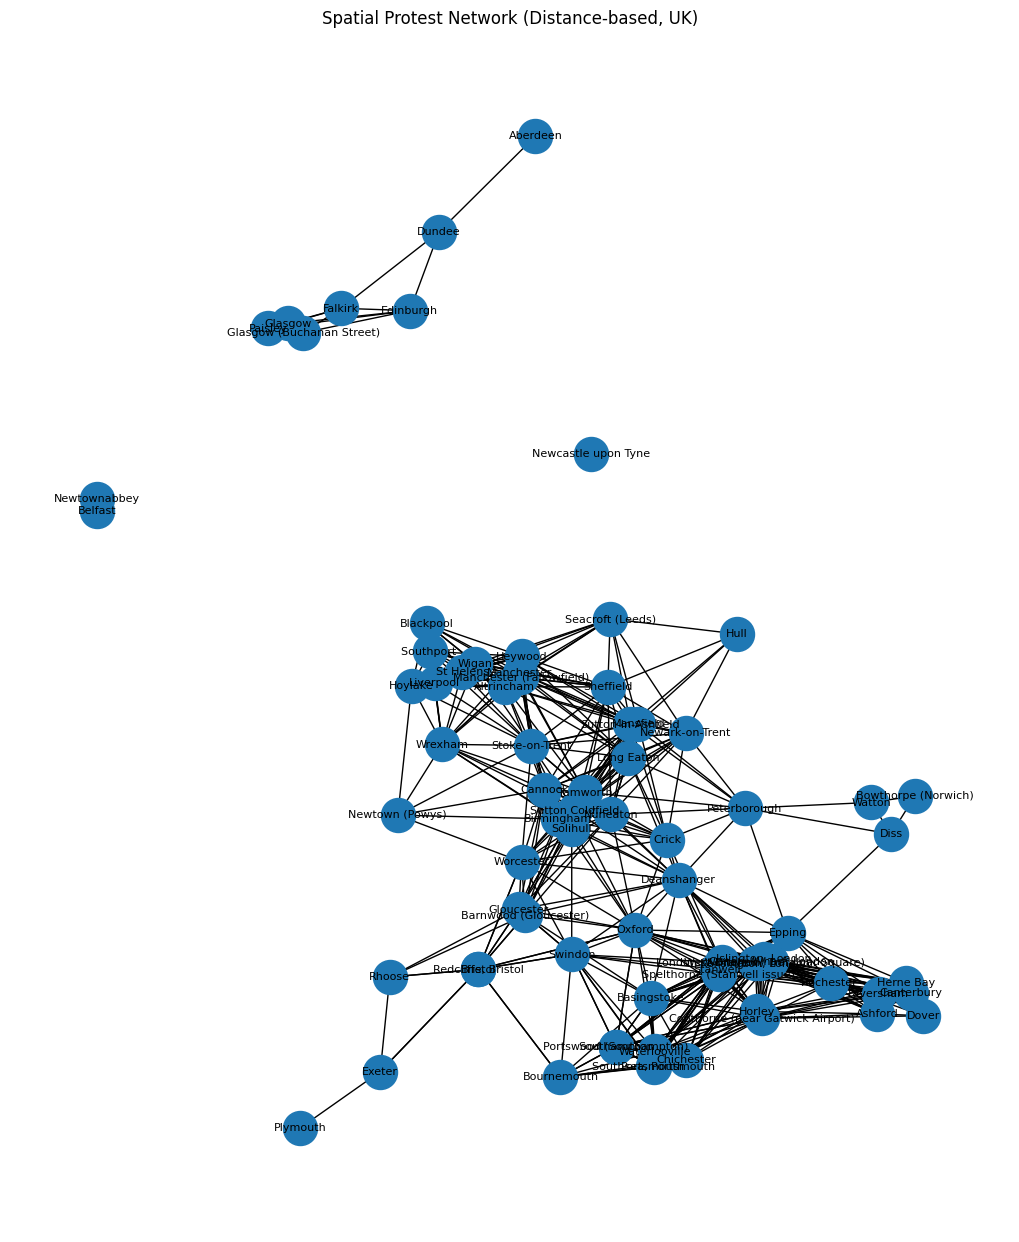

In [ ]:
plt.figure(figsize=(10, 12))

pos = {
    n: (G.nodes[n]["lon"], G.nodes[n]["lat"])
    for n in G.nodes()
}

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=600,
    font_size=8
)

plt.title("Spatial Protest Network (Distance-based, UK)")
plt.show()

In [ ]:
!rm /content/LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `rm /content/LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson'


In [ ]:
import geopandas as gpd

uk_map = gpd.read_file("/content/LAD_MAY_2025_UK_BFC_V2_481919774574330966.geojson")
uk_map.head()

,FID,LAD25CD,LAD25NM,LAD25NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E06000001,Hartlepool,,447161,531473,-1.270174,54.676132,847f2c4b-a7cf-4c71-840c-0864853246d5,"MULTIPOLYGON (((-1.2247 54.62611, -1.22493 54...."
1,2,E06000002,Middlesbrough,,451141,516887,-1.210998,54.544679,f1925b75-6267-417d-a77a-05cdc4c6b1b3,"MULTIPOLYGON (((-1.2772 54.54784, -1.27721 54...."
2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.006565,54.567520,36b1db27-3dfa-4ed6-8e81-36bf3abeeacc,"MULTIPOLYGON (((-1.20098 54.57763, -1.2003 54...."
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.306646,54.556876,22a6adf7-e812-4c09-89b1-6753ec35de93,"MULTIPOLYGON (((-1.27211 54.55337, -1.27213 54..."
4,5,E06000005,Darlington,,428029,515648,-1.568356,54.535345,309364b5-9b5c-4f9c-81f5-8a3a79699fd1,"POLYGON ((-1.63768 54.61714, -1.63767 54.6167,..."


In [ ]:
!ls /content

'Copy support-local-authority-datasets-sep-2025.xlsx'   sample_data
 LAD_MAY_2025_UK_BFC_V2_481919774574330966.geojson


In [ ]:
uk_map = uk_map.to_crs("EPSG:4326")

In [ ]:
from shapely.geometry import Point
import pandas as pd

city_df = pd.DataFrame({
    "city": list(G.nodes()),
    "latitude": [G.nodes[n]["lat"] for n in G.nodes()],
    "longitude": [G.nodes[n]["lon"] for n in G.nodes()]
})

geometry = [Point(xy) for xy in zip(city_df["longitude"], city_df["latitude"])]
city_gdf = gpd.GeoDataFrame(city_df, geometry=geometry, crs="EPSG:4326")

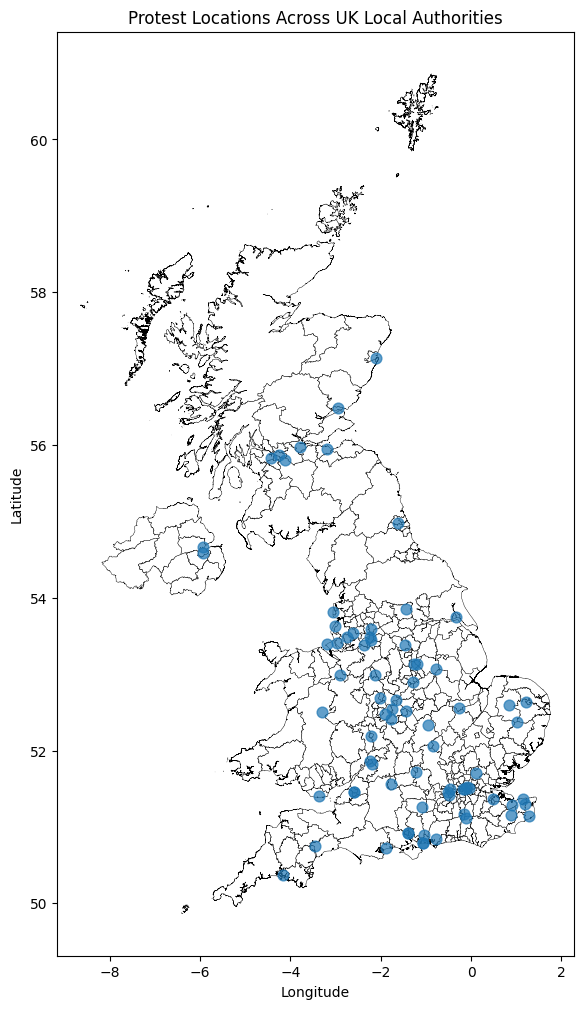

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

# Plot local authority boundaries
uk_map.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.3
)

# Plot protest city points
city_gdf.plot(
    ax=ax,
    markersize=60,
    alpha=0.7
)

ax.set_title("Protest Locations Across UK Local Authorities")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry column from lat/lon
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]

gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")


In [ ]:
uk_map = uk_map.to_crs(epsg=4326)

In [ ]:
gdf_with_la = gpd.sjoin(
    gdf,
    uk_map,
    how="left",
    predicate="within"
)

uk_map.columns

Index(['FID', 'LAD25CD', 'LAD25NM', 'LAD25NMW', 'BNG_E', 'BNG_N', 'LONG',
       'LAT', 'GlobalID', 'geometry'],
      dtype='object')

In [ ]:
gdf_with_la["local_authority"] = gdf_with_la["LAD25NM"]

In [ ]:
#gdf_with_la[["event_id", "town_city", "postcode", "local_authority", "LAD25CD"]].head()
protests_df = gdf_with_la[["event_id", "town_city", "postcode", "local_authority", "LAD25CD"]]

#rename the columns to make things easier later
protests_df = protests_df.rename(columns={
    "LAD25CD": "lad_code",
})

protests_df

,event_id,town_city,postcode,local_authority,lad_code
0,U0011,Liverpool,L1 1JW,Liverpool,E08000012
1,E0060,Aberdeen,AB10 1BL,Aberdeen City,S12000033
2,E0036,Aberdeen,AB25 1XF,Aberdeen City,S12000033
3,E0004,Birmingham,B1 1BD,Birmingham,E08000025
4,E0048,Sutton Coldfield,B76 1LH,Birmingham,E08000025
...,...,...,...,...,...
121,E0044,Altrincham,WA14 4DP,Trafford,E08000009
122,E0074,Wigan,WN1 1PE,Wigan,E08000010
123,E0050,Worcester,WR1 2AP,Worcester,E07000237
124,E0037,Cannock,WS11 1SH,Cannock Chase,E07000192


In [ ]:
protests_df.dtypes

,0
event_id,object
town_city,object
postcode,object
local_authority,object
lad_code,object


In [ ]:

#change the data types accordingly so we can work with the data usign pandas
protests_df['event_id']=protests_df['event_id'].astype('string')
protests_df['town_city']=protests_df['town_city'].astype('category')
protests_df['postcode']=protests_df['postcode'].astype('category')
protests_df['local_authority']=protests_df['local_authority'].astype('category')

In [ ]:
import pandas as pd

xls = pd.ExcelFile("/content/Copy support-local-authority-datasets-sep-2025.xlsx")
print("Available Excel sheets:", xls.sheet_names)


pop_df = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    sheet_name="population_per_LA", # Changed to include the trailing space
    header=0,
    engine="openpyxl"
)
pop_df.head()

Available Excel sheets: ['Cover_sheet', 'Contents', 'Notes', 'List_of_Fields', 'Asy_D11', 'Data_Asy_D11', 'Data_Asy_20242025', 'Data_Asy_2425', 'Data_Asy_D11_2020_2025', 'population_per_LA', 'la_exposure_table', 'Sheet4', 'la_exposure_table_old', '2025', 'protest_data', 'population for local authoritie']


,lad_code,name,geography,population,Isy
0,E06000047,County Durham,Unitary Authority,538011,True
1,E06000005,Darlington,Unitary Authority,112489,True
2,E06000001,Hartlepool,Unitary Authority,98180,True
3,E06000002,Middlesbrough,Unitary Authority,156161,True
4,E06000057,Northumberland,Unitary Authority,331420,True


In [ ]:
pop_df.columns
pop_df["lad_code"].nunique()


354

In [ ]:
df_contingency = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    sheet_name="la_exposure_table",
    engine="openpyxl"
)
df_contingency.head()

,index,lad_code,local_authority,population,total_asylum,contingency_per_1000,contingency_share,delta_contingency_Q1_Q3
0,0,E07000121,Lancaster,145006,239,0.0000,0.0000,0
1,1,E08000034,Kirklees,447847,748,0.0000,0.0000,0
2,2,E06000062,West Northamptonshire,439811,486,0.9186,0.8313,203
3,3,E07000181,West Oxfordshire,120941,239,1.9431,0.9833,77
4,4,E08000011,Knowsley,162565,312,0.0000,0.0000,0


In [ ]:
print("local_authorities:", len(df_contingency))

local_authorities: 348


In [ ]:
uk_map = uk_map.merge(
    df_contingency,
    left_on="LAD25NM", # Corrected from "local_authority"
    right_on="local_authority",
    how="left"
)

uk_map[["local_authority", "contingency_per_1000", "contingency_share", "delta_contingency_Q1_Q3"]].head()

,local_authority,contingency_per_1000,contingency_share,delta_contingency_Q1_Q3
0,Hartlepool,0.0000,0.0000,0.0
1,Middlesbrough,0.0000,0.0000,0.0
2,Redcar and Cleveland,0.0000,0.0000,0.0
3,Stockton-on-Tees,0.1499,0.0385,12.0
4,Darlington,0.0000,0.0000,0.0


In [ ]:
map_codes = set(uk_map["LAD25CD"])
data_codes = set(df_contingency["lad_code"])

print("Map authorities:", len(map_codes))
print("Data authorities:", len(data_codes))
print("Matching authorities:", len(map_codes & data_codes))

Map authorities: 361
Data authorities: 341
Matching authorities: 339


In [ ]:
df_contingency["lad_code"].str[0].value_counts()

,count
lad_code,
E,293
S,25
W,20
N,10


In [ ]:
map_with_data = uk_map[uk_map["contingency_per_1000"].notna()]

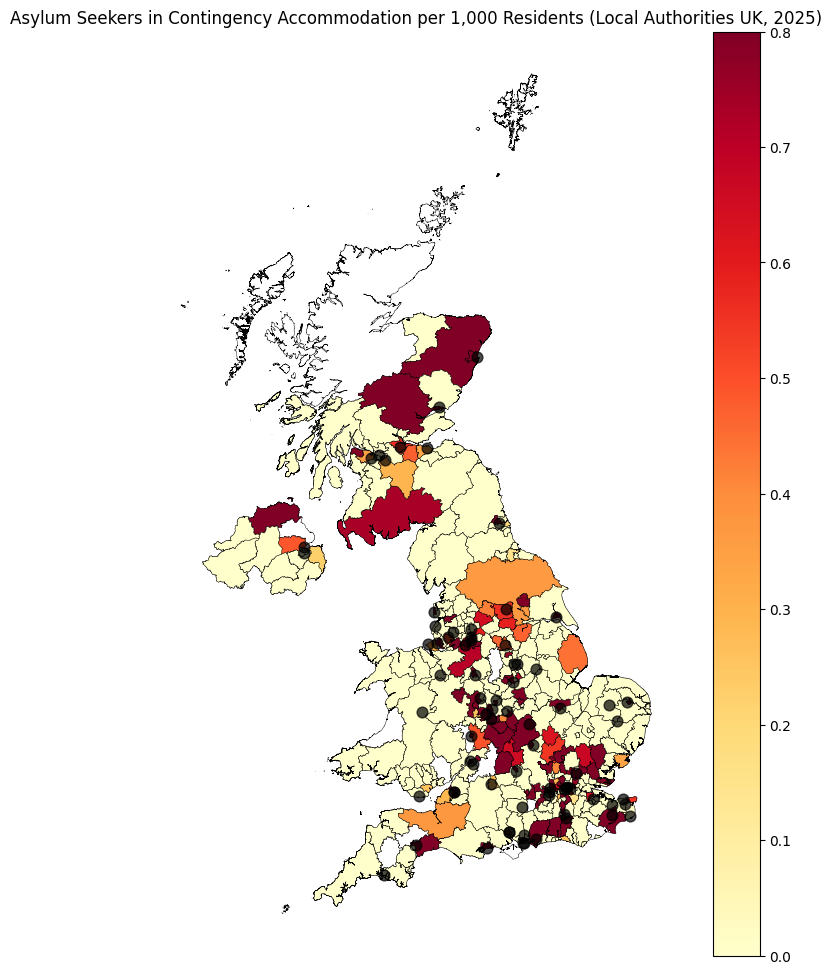

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))

uk_map.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.3
)


map_with_data.plot(
    column="contingency_per_1000",
    cmap="YlOrRd",
    legend=True,
    linewidth=0.3,
    edgecolor="black",
     vmin=0,
    vmax=0.8,
    ax=ax
)

city_gdf.plot(
    ax=ax,
    markersize=60,
    color="black",
    alpha=0.7
)

ax.set_title("Asylum Seekers in Contingency Accommodation per 1,000 Residents (Local Authorities UK, 2025)")
ax.axis("off")

plt.show()

KeyError: 'contingency_share'

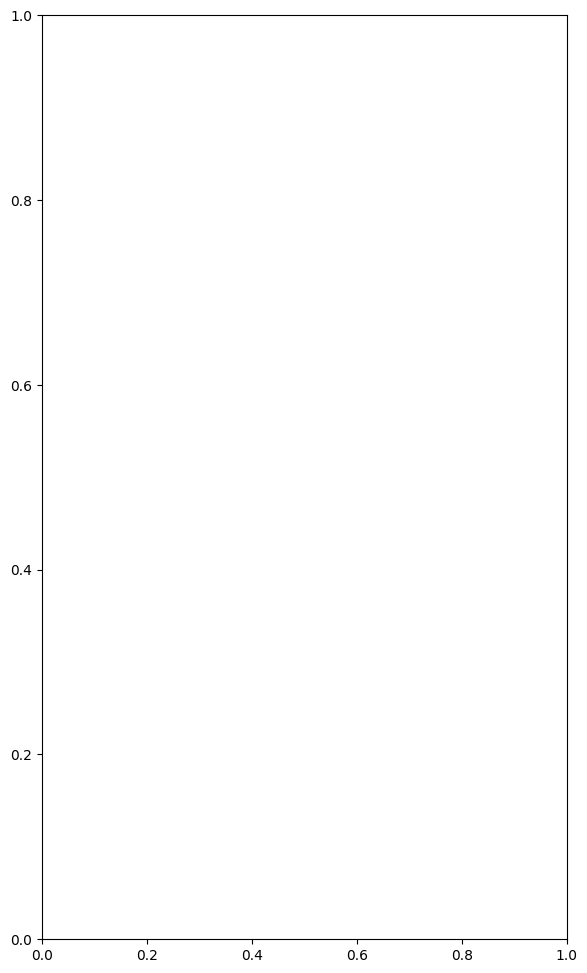

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

uk_map.plot(
    column="contingency_share",
    cmap="Blues",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
     vmin=0,
    vmax=0.4,
    ax=ax
)

city_gdf.plot(
    ax=ax,
    markersize=60,
    color="black",
    alpha=0.7
)

ax.set_title("Share of Asylum Seekers in Contingency Accommodation by UK Local Authority Q3-2025", fontsize=14)
ax.axis("off")

plt.show()

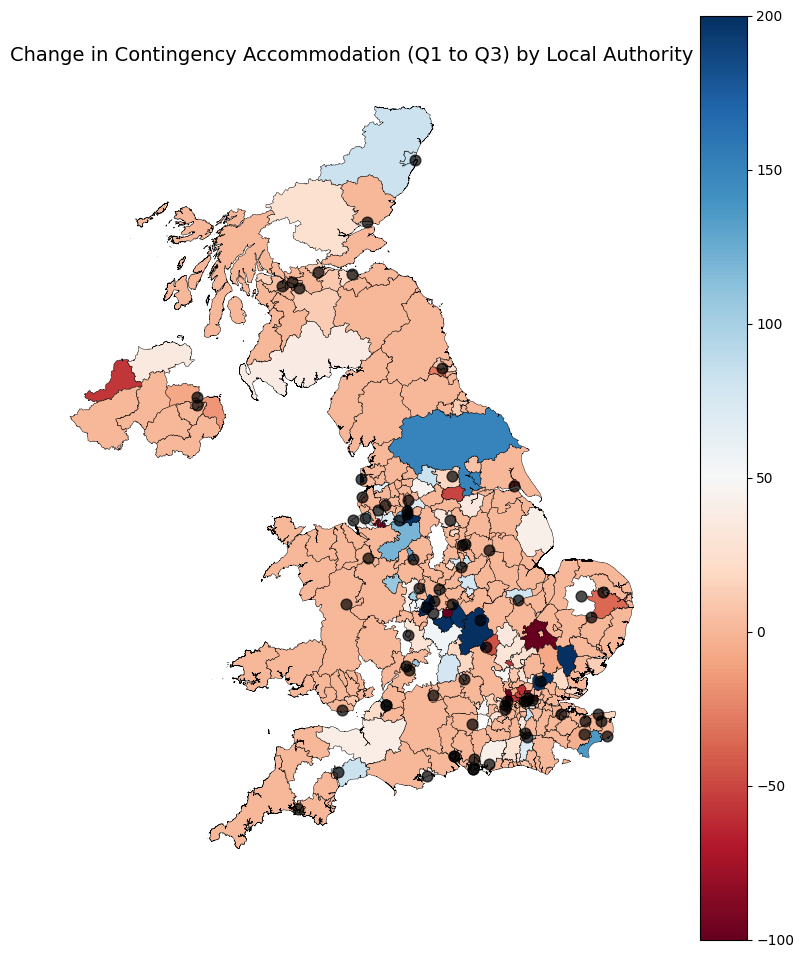

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

uk_map.plot(
    column="delta_contingency_Q1_Q3",
    cmap="RdBu",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
     vmin=-100,
    vmax=200,
    ax=ax
)

city_gdf.plot(
    ax=ax,
    markersize=60,
    color="black",
    alpha=0.7
)

ax.set_title("Change in Contingency Accommodation (Q1 to Q3) by Local Authority", fontsize=14)
ax.axis("off")

plt.show()

In [ ]:
la_exposure = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    sheet_name="la_exposure",
    engine="openpyxl"
)
la_exposure.head()

,index,lad_code,local_authority,population,total_asylum_2025_cumulative,total_asylumQ3,contingency_per_1000,delta_contingency_Q1_Q3,total_contingency,contingency_shareQ3,contingency_share_2025_cumulative
0,338,N09000011,Ards and North Down,165415,131,37,0.2237,-16,131,1.0000,1.0000
1,206,E07000221,Stratford-on-Avon,146258,333,138,0.9435,55,332,1.0000,0.9970
2,238,E07000040,East Devon,158239,653,269,1.7000,82,650,1.0000,0.9954
3,271,S12000006,Dumfries and Galloway,145860,281,107,0.7336,38,279,1.0000,0.9929
4,43,S12000040,West Lothian,186440,257,89,0.4720,9,255,0.9888,0.9922


In [ ]:
uk_map2 = uk_map2.merge(
    la_exposure,
    left_on="LAD25NM",
    right_on="local_authority",
    how="left"
)

uk_map2[["local_authority", "total_asylum_2025_cumulative", "total_asylumQ3", "contingency_per_1000", "delta_contingency_Q1_Q3", "total_contingency", "contingency_shareQ3", "contingency_share_2025_cumulative"]].head()

,local_authority,total_asylum_2025_cumulative,total_asylumQ3,contingency_per_1000,delta_contingency_Q1_Q3,total_contingency,contingency_shareQ3,contingency_share_2025_cumulative
0,Hartlepool,1314.0,431.0,0.0000,0.0,0.0,0.0000,0.0000
1,Middlesbrough,2094.0,673.0,0.0000,0.0,0.0,0.0000,0.0000
2,Redcar and Cleveland,777.0,254.0,0.0000,0.0,0.0,0.0000,0.0000
3,Stockton-on-Tees,2384.0,805.0,0.1499,12.0,68.0,0.0385,0.0285
4,Darlington,675.0,220.0,0.0000,0.0,0.0,0.0000,0.0000


In [ ]:
map_codes = set(uk_map2["LAD25CD"])
data_codes = set(la_exposure["lad_code"])

print("Map authorities:", len(map_codes))
print("Data authorities:", len(data_codes))
print("Matching authorities:", len(map_codes & data_codes))

Map authorities: 361
Data authorities: 345
Matching authorities: 343


In [ ]:
map_with_data = uk_map2[uk_map2["contingency_share_2025_cumulative"].notna()]

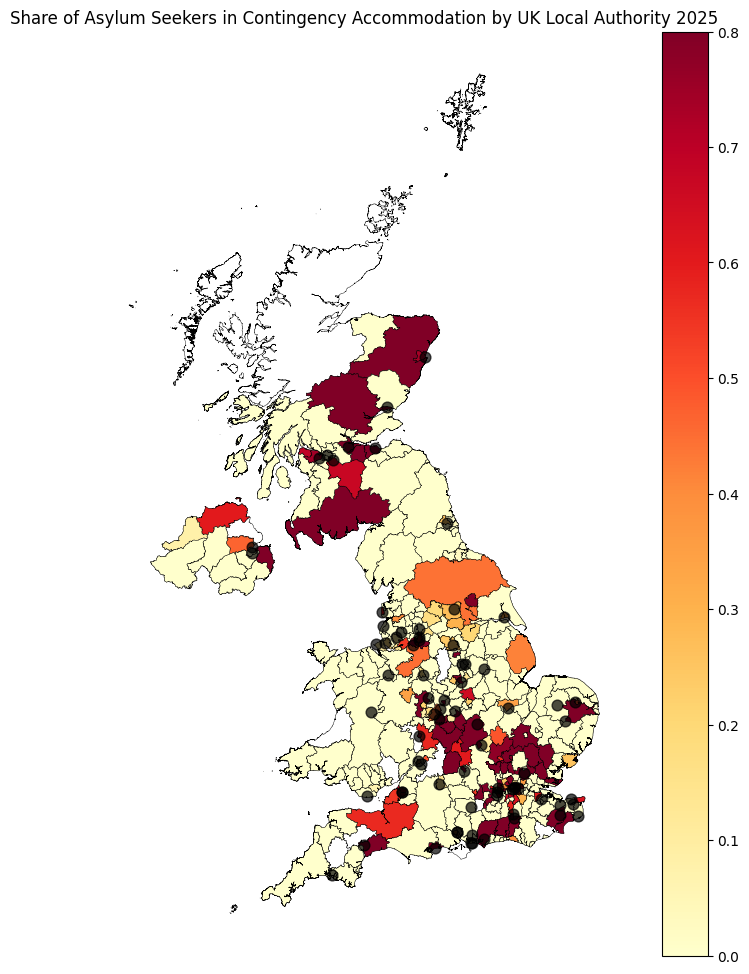

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))

uk_map2.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.3
)


map_with_data.plot(
    column="contingency_share_2025_cumulative",
    cmap="YlOrRd",
    legend=True,
    linewidth=0.3,
    edgecolor="black",
     vmin=0,
    vmax=0.8,
    ax=ax
)

city_gdf.plot(
    ax=ax,
    markersize=60,
    color="black",
    alpha=0.7
)

ax.set_title("Share of Asylum Seekers in Contingency Accommodation by UK Local Authority 2025")
ax.axis("off")

plt.show()